# 案例：股票收益率预测—RNN


接上一节内容，本节使用长短期记忆模型（RNN）来回归股票收益率序列。

In [1]:
import pandas as pd
X_train = pd.read_csv('datasets/X_train.csv', index_col=0)
X_test = pd.read_csv('datasets/X_test.csv', index_col=0, date_format='%Y%m%d')
y_train = pd.read_csv('datasets/y_train.csv', index_col=0)
y_test = pd.read_csv('datasets/y_test.csv', index_col=0)

In [2]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

## 7. 深度学习模型——RNN

现在让我们为 RNN 模型准备数据集。我们需要所有输入变量和输出变量的数组形式的数据。

RNN 背后的逻辑是，数据取自前 $n$ 天（当天相关资产的所有其他特征数据和 MSFT 的滞后变量），我们尝试预测第 $n+1$ 天。然后，我们将窗口移动一天，再次预测第二天。我们对整个数据集进行这样的重复（当然是分批进行）。

初始化模型的训练集和测试集：

In [20]:
import numpy as np
time_steps = 10                    # 窗口长度
feature_n = X_train.shape[1]
# 单个样本的大小为 seq_len * feature_n
X_train_RNN = np.zeros((X_train.shape[0], time_steps, feature_n))  
y_train_RNN = np.zeros((X_train.shape[0], feature_n))  
X_test_RNN = np.zeros((X_test.shape[0], time_steps, feature_n))  
y_test_RNN = np.zeros((X_test.shape[0], feature_n))  

In [21]:
X_train_RNN.shape, y_train_RNN.shape

((540, 10, 11), (540, 11))

In [22]:
for i in range(X_train.shape[0]-time_steps):
    X_train_RNN[i, :, :] = X_train.iloc[i:i+time_steps,:]
    y_train_RNN[i] = y_train.iloc[i+time_steps]

In [23]:
for i in range(X_test.shape[0]-time_steps):
    X_test_RNN[i, :, :] = X_test.iloc[i:i+time_steps,:]
    y_test_RNN[i] = y_test.iloc[i+time_steps]

调用keras库的RNN模型

In [24]:
from keras.models import Sequential 
from keras.layers import SimpleRNN, Dense
from keras.optimizers.legacy import SGD, Adam 

In [25]:
input_shape=(time_steps, feature_n)
output_units = feature_n      

In [26]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_steps, feature_n)))
model.add(Dense(feature_n))
model.compile(loss='mean_squared_error', optimizer='adam')

下面开始训练模型，

In [27]:
model_fit = model.fit(X_train_RNN, y_train_RNN,
                      validation_data=(X_test_RNN,y_test_RNN),
                      epochs=100,
                      batch_size=50,
                      verbose=1,
                      shuffle=False)

Epoch 1/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123 - val_loss: 0.0065
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 11/

现在，我们用数据拟合 RNN 模型，同时在训练集和测试集中观察模型性能指标随时间的变化：

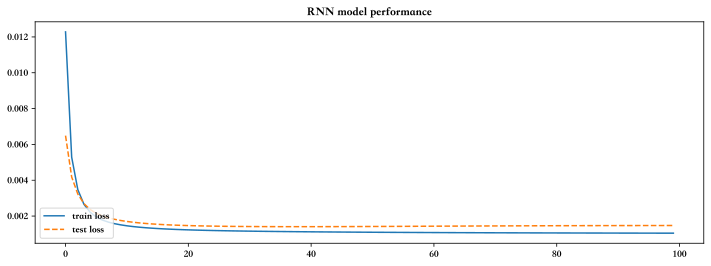

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Songti SC'  # 设置字体为宋体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号“-”显示异常
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

plt.figure(figsize=(12,4))
plt.plot(model_fit.history['loss'], label='train loss', )
plt.plot(model_fit.history['val_loss'], '--',label='test loss',)
plt.title('RNN model performance')
plt.legend(loc='lower left')
plt.show()

随着训练的轮数增加，训练集和测试集的误差在同步下降。

## 8. 模型对比

In [15]:
train_results, test_results, names = [], [], []
# LR
train_results.append(0.001146)
test_results.append(0.00129)

# ARIMA
train_results.append(0.001139)
test_results.append(0.001246)

# RNN
train_results.append(0.0010)
test_results.append(0.0014)

names.append("LR")
names.append("ARIMA")
names.append("RNN")

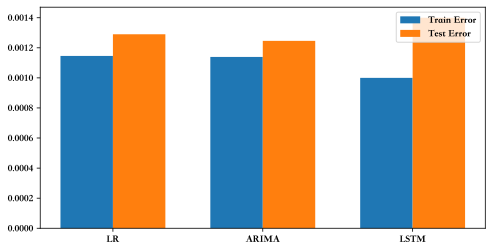

In [16]:
ind = np.arange(len(names))
width = 0.35
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.bar(ind-width/2, train_results, width=width, label='Train Error')
plt.bar(ind+width/2, test_results, width=width, label='Test Error')
plt.xticks(ind)
ax.set_xticklabels(names)
plt.legend()
plt.show()

## 结论

本案例研究将利用3种（LR、ARIMA、RNN）模型，结合股票的相关资产及其自身历史数据，来预测其股票价格。本案例研究，提供了股票预测建模的一般机器学习方法，涵盖从数据收集和清理，到构建和调整不同模型的整个过程。研究发现，RNN代表的非线性模型在误差，相比于线性模型（LR、ARIMA）有较好的表现。